# Sentiment Analysis of a Telegram Channel with PySpark

## Summary: 
The current study centers on the analysis of the posts of a Telegram channel with PySpark. In particular, the Huobi Telegram channel is selected, a channel focused on discussing the trading of cryptocurrencies. The employed dataset, **group_messages_huobi.json** has been obtained from https://www.kaggle.com/aagghh/crypto-telegram-groups?select=group_messages_huobi.json, and it contains around 550,000 user posts. The objectives of this study are as follows:
* To analyze each of the fields in the JSON dataset, extracting the number of missing and unique values of each attribute.
* To determine the hours of the day and the days of the week in which the channel is most active.
* To determine what the most frequently mentioned cryptocurrencies are, as well as the evolution of their mentions.
* To compare the evolution of mentions of the most popular cryptocurrencies with their trading price.
* To assign a sentiment value to each of the posts in the dataset, and observe the evolution of the channel's overall sentiment with time.

## 1. PySpark Environment Setup


In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.getOrCreate()

In [3]:
from IPython.display import display, Markdown
from pyspark.sql.functions import *

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

## 2. Reading the Dataset as a PySpark DataFrame

In [5]:
df = spark.read.json("group_messages_huobi.json", multiLine=True)
df.printSchema()

root
 |-- _: string (nullable = true)
 |-- action: struct (nullable = true)
 |    |-- _: string (nullable = true)
 |    |-- chat_id: long (nullable = true)
 |    |-- game_id: long (nullable = true)
 |    |-- photo: struct (nullable = true)
 |    |    |-- _: string (nullable = true)
 |    |    |-- access_hash: long (nullable = true)
 |    |    |-- date: timestamp (nullable = true)
 |    |    |-- dc_id: long (nullable = true)
 |    |    |-- file_reference: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- has_stickers: boolean (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- sizes: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- _: string (nullable = true)
 |    |    |    |    |-- bytes: array (nullable = true)
 |    |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |    |-- h: long (nullable = true)
 |    |    |    |    |-- location:

To simplify the analysis, given the long list of attributes in this DataFrame, only the following are employed:
* date: Timestamp representing the time of the message
* message: The post string
* id: An ID for each post
* from_id.user_id: The post's author ID.

Moreover, the dataset is truncated to allow for faster processing.

In [6]:
df = df.select([
    col('id').alias('Post_ID'), 
    col('date').alias('Timestamp'), 
    col('message').alias('Message'), 
    col('from_id.user_id').alias('Author_ID')
]).limit(250000)
df.limit(10).toPandas()

,Post_ID,Timestamp,Message,Author_ID
0,1018295,2021-01-27 13:18:20,"I'm confused about how to find my balance, whi...",378862929
1,1018294,2021-01-27 13:15:16,⚠️ Important Reminder ☠️\n\n🚫 Huobi Global doe...,210944655
2,1018293,2021-01-27 12:52:45,Until when is the Kyc video review?,520934873
3,1018288,2021-01-27 12:42:54,"Hello there welcome, how may I help you today?",612816754
4,1018287,2021-01-27 12:42:32,No,612816754
5,1018286,2021-01-27 12:41:18,Hi guys,1399987656
6,1018281,2021-01-27 12:38:47,"Hi team, are Huobi cooperate with NEUMEOKCA?",1166637481
7,1018276,2021-01-27 12:32:17,Huobi team will never call you.\nStay safe,524337332
8,1018275,2021-01-27 12:31:51,It's a typical scam call MD⚠️⚠️⚠️,524337332
9,1018273,2021-01-27 12:28:38,"Hi, I got a call from a private number few hou...",427029442


## 3. Examining the Number of NaNs and Unique Values in Each Column

In [7]:
print("Checking for nulls on columns Post_ID, Timestamp, Message and Author_ID:")
df.select([count(when(col(c).isNull(), c)).alias(c) for c in ["Post_ID","Timestamp","Message","Author_ID"]]).show()

Checking for nulls on columns Post_ID, Timestamp, Message and Author_ID:
+-------+---------+-------+---------+
|Post_ID|Timestamp|Message|Author_ID|
+-------+---------+-------+---------+
|      0|        0|  31210|      468|
+-------+---------+-------+---------+



In [8]:
print("Checking amount of distinct values in columns Post_ID, Timestamp, Message and Author_ID:")
df.select([countDistinct(c).alias(c) for c in ["Post_ID","Timestamp","Message","Author_ID"]]).show()

Checking amount of distinct values in columns Post_ID, Timestamp, Message and Author_ID:
+-------+---------+-------+---------+
|Post_ID|Timestamp|Message|Author_ID|
+-------+---------+-------+---------+
| 250000|   238729| 134943|    59147|
+-------+---------+-------+---------+



## 4. Determining the Most Active Days of the Week and Hours of the Day

### 4.1 Obtaining auxiliary columns for Date, Day of the Week, and Hour of the Day

In [9]:
df = df\
    .withColumn('Date', to_date(col('Timestamp')))\
    .withColumn('Day_of_Week', dayofweek(col('Timestamp')))\
    .withColumn('Hour_of_Day', hour(col('Timestamp')))\
    .cache()
df.limit(10).toPandas()

,Post_ID,Timestamp,Message,Author_ID,Date,Day_of_Week,Hour_of_Day
0,1018295,2021-01-27 13:18:20,"I'm confused about how to find my balance, whi...",378862929,2021-01-27,4,13
1,1018294,2021-01-27 13:15:16,⚠️ Important Reminder ☠️\n\n🚫 Huobi Global doe...,210944655,2021-01-27,4,13
2,1018293,2021-01-27 12:52:45,Until when is the Kyc video review?,520934873,2021-01-27,4,12
3,1018288,2021-01-27 12:42:54,"Hello there welcome, how may I help you today?",612816754,2021-01-27,4,12
4,1018287,2021-01-27 12:42:32,No,612816754,2021-01-27,4,12
5,1018286,2021-01-27 12:41:18,Hi guys,1399987656,2021-01-27,4,12
6,1018281,2021-01-27 12:38:47,"Hi team, are Huobi cooperate with NEUMEOKCA?",1166637481,2021-01-27,4,12
7,1018276,2021-01-27 12:32:17,Huobi team will never call you.\nStay safe,524337332,2021-01-27,4,12
8,1018275,2021-01-27 12:31:51,It's a typical scam call MD⚠️⚠️⚠️,524337332,2021-01-27,4,12
9,1018273,2021-01-27 12:28:38,"Hi, I got a call from a private number few hou...",427029442,2021-01-27,4,12


### 4.2 Examining the temporal extent of the dataset

In [10]:
print("Checking amount of distinct values in columns Post_ID, Date, Day_of_Week and Hour_of_Day:")
df.select([countDistinct(c).alias(c) for c in ["Post_ID","Date","Day_of_Week","Hour_of_Day"]]).show()

Checking amount of distinct values in columns Post_ID, Date, Day_of_Week and Hour_of_Day:
+-------+----+-----------+-----------+
|Post_ID|Date|Day_of_Week|Hour_of_Day|
+-------+----+-----------+-----------+
| 250000| 612|          7|         24|
+-------+----+-----------+-----------+



In [11]:
df.select(expr("MIN(DATE) AS MIN_DATE"), expr("MAX(DATE) AS MAX_DATE")).show()

+----------+----------+
|  MIN_DATE|  MAX_DATE|
+----------+----------+
|2019-05-27|2021-01-27|
+----------+----------+



As we can see, the dataset spans over 612 days, from 2019-05-27 to 2021-01-27.

### 4.3 Obtaining the most active days of the week

In [12]:
summary_week = df.groupBy(col('Day_of_Week')).count().orderBy(col('count').desc()).toPandas()
summary_week

,Day_of_Week,count
0,4,40296
1,3,39802
2,2,38653
3,5,38589
4,6,38042
5,7,28797
6,1,25821


<AxesSubplot:title={'center':'Group Activity during the Week'}, xlabel='Day of the Week', ylabel='Percentage of Weekly Posts'>

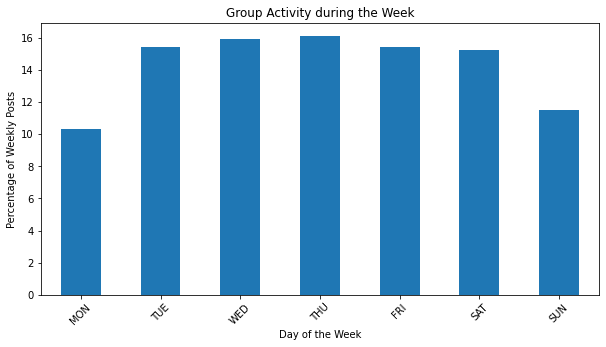

In [13]:
weekday_abbreviations = {4:'THU', 3:'WED', 2:'TUE', 5:'FRI', 6:'SAT', 7:'SUN', 1:'MON'}
total_posts = summary_week['count'].sum()
summary_week\
    .sort_values('Day_of_Week')\
    .replace({'Day_of_Week':weekday_abbreviations})\
    .apply(lambda x: x * 100 / total_posts if x.name == 'count' else x)\
    .plot.bar(x='Day_of_Week', y='count', 
        title='Group Activity during the Week', 
        rot=45,
        xlabel='Day of the Week',
        ylabel='Percentage of Weekly Posts',
        legend=False,
        figsize=(10, 5))

As we can see, **Thursdays** are the most active days of the week for this channel, followed very closely by Wednesdays, Tuesdats, and Fridays.

### 4.4 Obtaining the most active hours of the day

In [14]:
summary_day = df.groupBy(col('Hour_of_Day')).count().orderBy(col('count').desc()).toPandas()
summary_day

,Hour_of_Day,count
0,13,21299
1,14,18897
2,15,17321
3,11,14469
4,16,13411
5,10,13335
6,12,13134
7,9,12479
8,17,12122
9,18,11124


<AxesSubplot:title={'center':'Group Activity during the Day'}, xlabel='Hour of the Day', ylabel='Percentage of Daily Posts'>

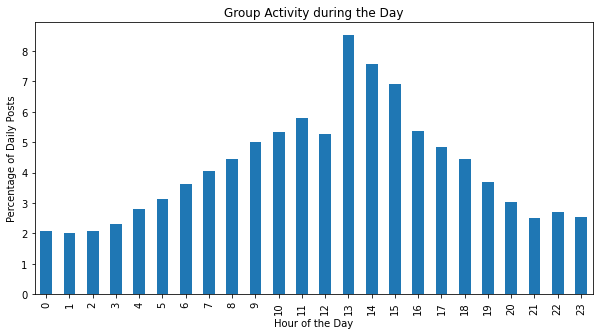

In [15]:
total_posts = summary_day['count'].sum()
summary_day\
    .sort_values('Hour_of_Day')\
    .apply(lambda x: x * 100 / total_posts if x.name == 'count' else x)\
    .plot.bar(x='Hour_of_Day', y='count', 
        title='Group Activity during the Day', 
        xlabel='Hour of the Day',
        ylabel='Percentage of Daily Posts',
        legend=False,
        figsize=(10, 5))

As one can see, there is a prominent peak in group activity at **13:00** hours UTC.

## 5. Determining the Most Mentioned Cryptocurrencies and their Temporal Evolution

### 5.1 Adding columns indicating if "Message" contains each currency

The top cryptocurrencies in terms of capitalization are taken, from https://coinmarketcap.com/. Here, a dictionary of possible ways users could refer to them is defined, assuming capitalized "Message". Common parts of words, like 'DOT' and 'ADA' need special care.

In [16]:
top_crypto = {'BTC': [' BTC ', 'BITCOIN', '$BTC'],
              'ETH': [' ETH ', 'ETHEREUM', '$ETH'],
              'XRP': [' XRP ', '$XRP'],
              'USDT': [' USDT ','TETHER', '$USDT'],
              'ADA': [' ADA ', 'CARDANO', '$ADA'],
              'DOT': [' DOT ', 'POLKADOT', 'POLKA', '$DOT'],
              'LTC': [' LTC ', 'LITECOIN', '$LTC'],
              'BNB': [' BNB ', 'BINANCE COIN', 'BINANCE', '$BNB'],
              'DOGE': [' DOGE ', 'DOGECOIN', '$DOGE'],
             }

In [17]:
for crypto in top_crypto.keys():
    column_name = 'Contains_' + crypto
    df = df.withColumn(column_name, lit(0))
    for c in top_crypto[crypto]:
        df = df.withColumn(column_name, when(upper(col('Message')).contains(c), 1).otherwise(col(column_name)))

df.select(['Message', 'Contains_DOT', 'Date']).filter('Contains_DOT == 1').limit(10).toPandas()

,Message,Contains_DOT,Date
0,"Hye, I see you can wd dot on heco chain , but ...",1,2021-01-26
1,Polkadot’s parachain communication (XCMP) and ...,1,2021-01-26
2,"You said that ""We need oracles both on Ethereu...",1,2021-01-26
3,Reef is a DeFi operating system powered by Pol...,1,2021-01-26
4,"Polkadot ecosystem is sounds new for me, why C...",1,2021-01-26
5,what makes Reef different from metamask's trad...,1,2021-01-26
6,Why is Reef using Polkadot's shared security m...,1,2021-01-26
7,"Polkadot, Matic, Covalent ... I am sure this i...",1,2021-01-26
8,#Polkadot is a multi-chain framework that supp...,1,2021-01-26
9,Is the creation of the Polkadot DeFi Alliance ...,1,2021-01-26


In [18]:
summary_contains = df\
    .select([col('Contains_' + c) for c in top_crypto.keys()])\
    .agg({'Contains_' + c: 'sum' for c in top_crypto.keys()})\
    .toPandas()\
    .T\
    .rename(columns={0:'Mentions'}, index={'sum(Contains_' + c + ')': c for c in top_crypto.keys()})

summary_contains

,Mentions
BNB,591
ADA,132
DOGE,118
BTC,2692
LTC,269
USDT,922
DOT,1046
XRP,249
ETH,1334


<AxesSubplot:title={'center':'Comparision of Mentions of Cryptocurrencies in Channel'}, xlabel='Cryptocurrency', ylabel='Mentions'>

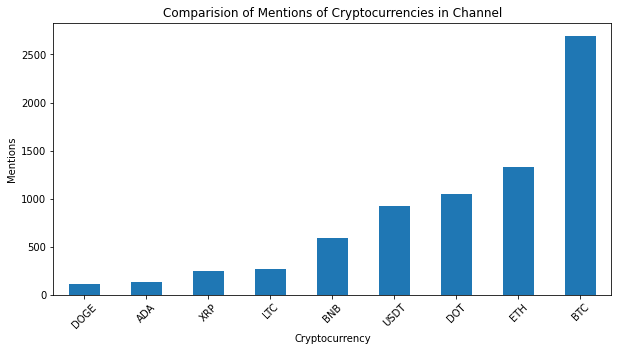

In [19]:
summary_contains\
    .sort_values('Mentions')\
    .plot.bar(y='Mentions',
        title='Comparision of Mentions of Cryptocurrencies in Channel', 
        xlabel='Cryptocurrency',
        ylabel='Mentions',
        legend=False,
        rot=45,
        figsize=(10, 5))

As we can see, **BTC** is by far the most discussed cryptocurrency, followed not too closely by USDT and ETH.

### 5.2 Observing the temporal evolution of a cryptocurrency's mentions

To this end, all that is necessary is to group the mentions by date, and to plot their evolutions.

In [20]:
grouped_by_date = df\
                    .select(['Date'] + ['Contains_' + c for c in top_crypto.keys()])\
                    .groupBy(col('Date'))\
                    .sum()\
                    .toPandas()\
                    .rename(columns={'sum(Contains_' + c + ')': c for c in top_crypto.keys()})\
                    .set_index('Date')
grouped_by_date

,BTC,ETH,XRP,USDT,ADA,DOT,LTC,BNB,DOGE
Date,,,,,,,,,
2021-01-27,2,0,0,5,1,0,0,0,0
2021-01-26,11,22,0,5,0,27,5,16,0
2021-01-25,11,6,0,5,4,1,0,8,0
2021-01-24,3,15,0,1,0,0,0,2,0
2021-01-23,5,2,0,7,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...
2019-05-31,3,1,0,0,0,0,0,0,1
2019-05-30,17,1,1,0,0,0,0,1,2
2019-05-29,12,0,1,0,1,0,0,1,0


Let's plot all the evolutions together first. This proves to be messy.

<AxesSubplot:title={'center':'Evolution of Daily Channel Mentions of each Cryptocurrency'}, xlabel='Date', ylabel='Daily Mentions'>

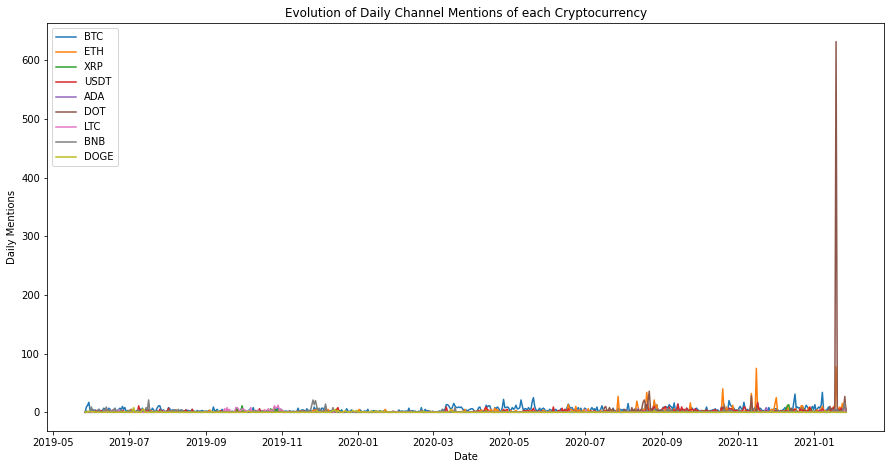

In [21]:
grouped_by_date.plot(figsize=(15, 7.5),
                     ylabel='Daily Mentions',
                     title='Evolution of Daily Channel Mentions of each Cryptocurrency')

<AxesSubplot:title={'center':'Evolution of Daily Channel Mentions of BTC'}, xlabel='Date', ylabel='Daily Mentions'>

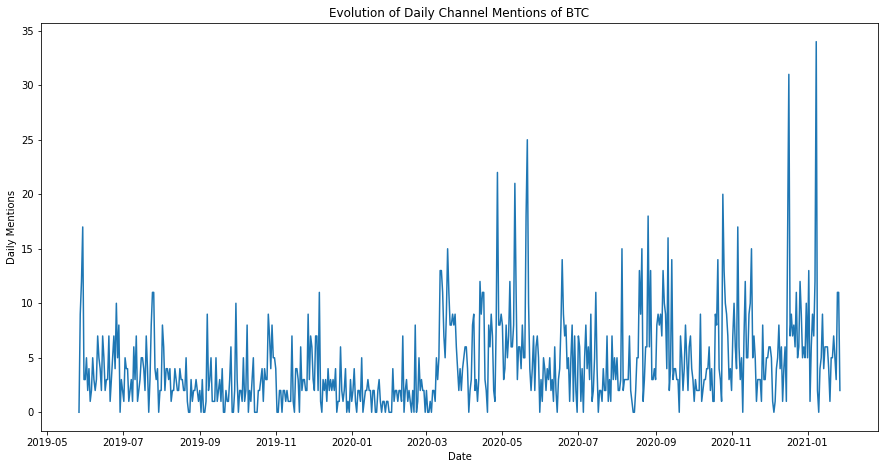

In [22]:
grouped_by_date['BTC'].plot(figsize=(15, 7.5),
                            ylabel='Daily Mentions',
                            title='Evolution of Daily Channel Mentions of BTC')

<AxesSubplot:title={'center':'Evolution of Daily Channel Mentions of ETH'}, xlabel='Date', ylabel='Daily Mentions'>

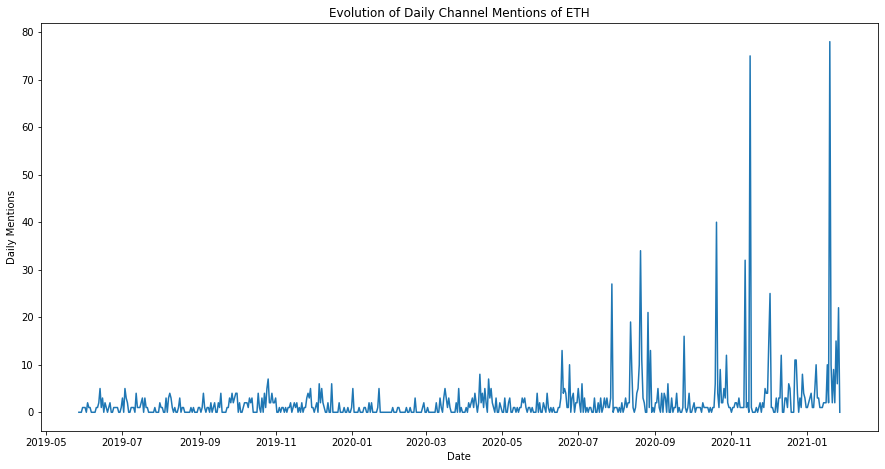

In [23]:
grouped_by_date['ETH'].plot(figsize=(15, 7.5),
                            ylabel='Daily Mentions',
                            title='Evolution of Daily Channel Mentions of ETH')

<AxesSubplot:title={'center':'Evolution of Daily Channel Mentions of DOT'}, xlabel='Date', ylabel='Daily Mentions'>

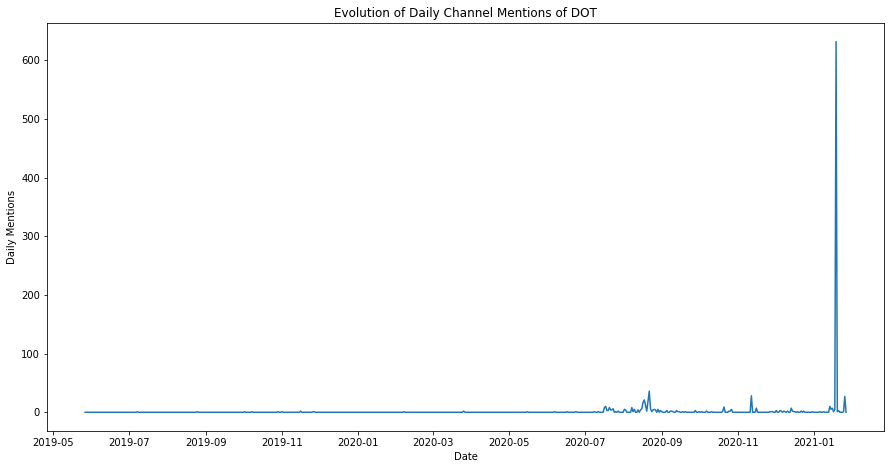

In [24]:
grouped_by_date['DOT'].plot(figsize=(15, 7.5),
                            ylabel='Daily Mentions',
                            title='Evolution of Daily Channel Mentions of DOT')

Something interesting must have happened with Polkadot in the end of January 2021. Perhaps some sort of spam.

### 5.3 Comparing the evolution of mentions with the price evolution

First, download the price data of each relevant cryptocurrency with `yfinance`. For this section, we will analyze only the following:
* BTC
* ETH
* DOT

In [25]:
tickers = ['BTC-USD', 'ETH-USD', 'DOT1-USD']
import yfinance as yf

In [26]:
prices = yf.download(tickers, start=grouped_by_date.index[-1], end=grouped_by_date.index[0])\
        .loc[:, 'Close']

[*********************100%***********************]  3 of 3 completed


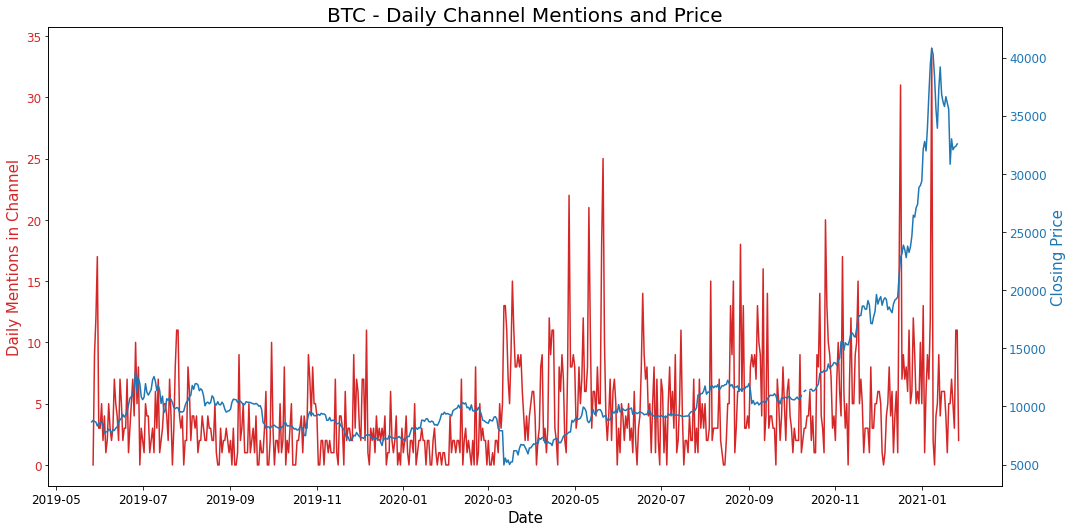

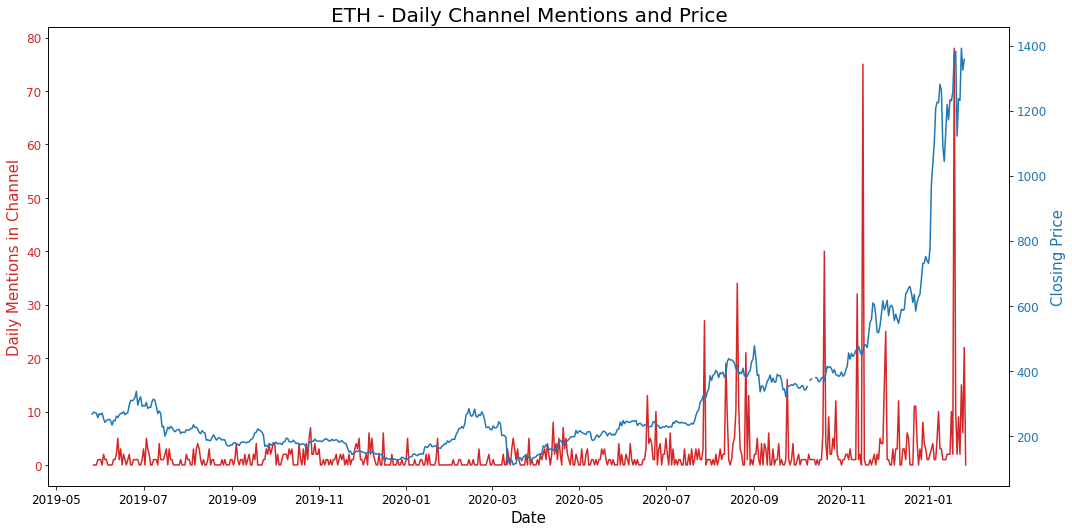

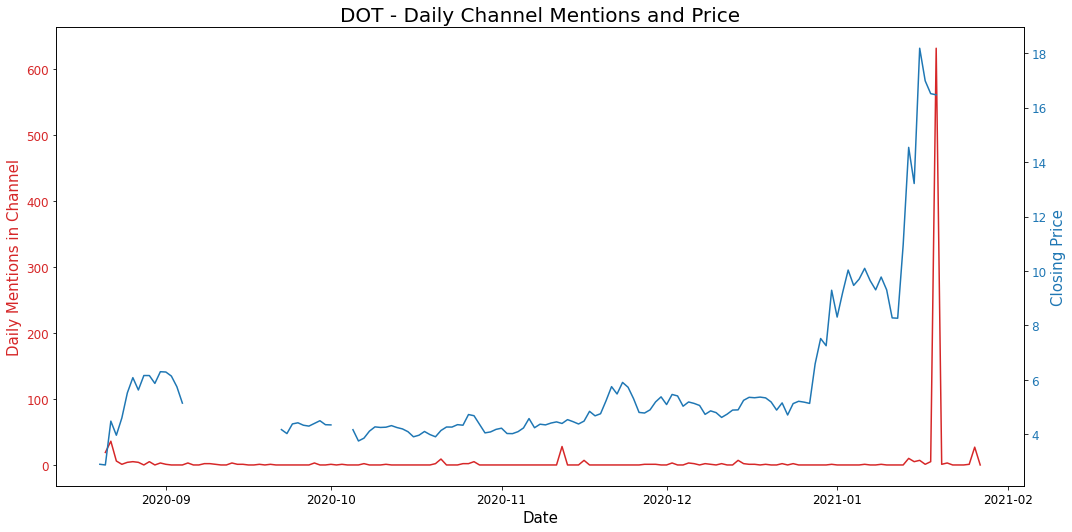

In [27]:
for i, crypto in enumerate(['BTC', 'ETH', 'DOT']): 
    
    start_date = prices[prices[tickers[i]].notna()].index[0]
    cut_price = prices.loc[prices.index > start_date, :]
    mentions_data = grouped_by_date.loc[grouped_by_date.index > start_date, :]
    
    fig, ax1 = plt.subplots()
    plt.title(crypto + ' - Daily Channel Mentions and Price', fontsize=20)
    fig.set_size_inches(15, 7.5)
    color = 'tab:red'
    ax1.set_xlabel('Date', fontsize=15)
    ax1.set_ylabel('Daily Mentions in Channel', color=color, fontsize=15)
    ax1.plot(mentions_data.index, mentions_data[crypto], color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Closing Price', color=color, fontsize=15) 
    ax2.plot(prices.index, prices[tickers[i]], color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=12)

    fig.tight_layout() 

We can definitely conclude that peaks in mentions come closely after quick rises in the price.

In [35]:
corr_mentions_prices = {}
for i, crypto in enumerate(['BTC', 'ETH', 'DOT']): 
    merged = pd.merge(grouped_by_date[crypto], prices[tickers[i]], left_index=True, right_index=True)
    corr_mentions_prices[crypto] = merged.corr().iloc[0, 1]
    
corr_mentions_prices

{'BTC': 0.2120916249394772,
 'ETH': 0.29476851924780767,
 'DOT': 0.34062862790959425}

## 6. Analyzing the Sentiment of Each Message

### 6.1 Isolating the words within each message

Before analyzing the sentiment of any message, it is necessary to split the message words into an array column. Special care is necessary to exclude `\n`, `,`, `?`, `!`, etc. from the original message string. Thus, a UDF is defined to carry out the task, and to make sure that no spaces are included in each word's string.

In [36]:
from pyspark.sql.types import ArrayType, FloatType, StringType

@udf(ArrayType(StringType()))
def clean_and_split_string(message):
    words = []
    if message is not None:
        unwanted = ['\n', ',', '?', '.', '!', ';', '¿', '¡']
        for patt in unwanted:
            message = message.replace(patt, ' ')
        words = [m.strip() for m in message.split(' ') if ((m != '') and (m != ' '))]
    return words

In [37]:
df_split = df.withColumn('Message_Words', clean_and_split_string(col('Message')))
df_split.select(['Message', 'Message_Words']).limit(20).toPandas()

,Message,Message_Words
0,"I'm confused about how to find my balance, whi...","[I'm, confused, about, how, to, find, my, bala..."
1,⚠️ Important Reminder ☠️\n\n🚫 Huobi Global doe...,"[⚠️, Important, Reminder, ☠️, 🚫, Huobi, Global..."
2,Until when is the Kyc video review?,"[Until, when, is, the, Kyc, video, review]"
3,"Hello there welcome, how may I help you today?","[Hello, there, welcome, how, may, I, help, you..."
4,No,[No]
5,Hi guys,"[Hi, guys]"
6,"Hi team, are Huobi cooperate with NEUMEOKCA?","[Hi, team, are, Huobi, cooperate, with, NEUMEO..."
7,Huobi team will never call you.\nStay safe,"[Huobi, team, will, never, call, you, Stay, safe]"
8,It's a typical scam call MD⚠️⚠️⚠️,"[It's, a, typical, scam, call, MD⚠️⚠️⚠️]"
9,"Hi, I got a call from a private number few hou...","[Hi, I, got, a, call, from, a, private, number..."


It is necessary to make sure that the UDF's output is specified correctly.

In [38]:
df_split.printSchema()

root
 |-- Post_ID: long (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- Message: string (nullable = true)
 |-- Author_ID: long (nullable = true)
 |-- Date: date (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Hour_of_Day: integer (nullable = true)
 |-- Contains_BTC: integer (nullable = false)
 |-- Contains_ETH: integer (nullable = false)
 |-- Contains_XRP: integer (nullable = false)
 |-- Contains_USDT: integer (nullable = false)
 |-- Contains_ADA: integer (nullable = false)
 |-- Contains_DOT: integer (nullable = false)
 |-- Contains_LTC: integer (nullable = false)
 |-- Contains_BNB: integer (nullable = false)
 |-- Contains_DOGE: integer (nullable = false)
 |-- Message_Words: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [39]:
df_split = df_split.withColumn('Single_Word', explode(col('Message_Words')))
df_split.select(['Message', 'Message_Words', 'Single_Word']).limit(10).toPandas()

,Message,Message_Words,Single_Word
0,"I'm confused about how to find my balance, whi...","[I'm, confused, about, how, to, find, my, bala...",I'm
1,"I'm confused about how to find my balance, whi...","[I'm, confused, about, how, to, find, my, bala...",confused
2,"I'm confused about how to find my balance, whi...","[I'm, confused, about, how, to, find, my, bala...",about
3,"I'm confused about how to find my balance, whi...","[I'm, confused, about, how, to, find, my, bala...",how
4,"I'm confused about how to find my balance, whi...","[I'm, confused, about, how, to, find, my, bala...",to
5,"I'm confused about how to find my balance, whi...","[I'm, confused, about, how, to, find, my, bala...",find
6,"I'm confused about how to find my balance, whi...","[I'm, confused, about, how, to, find, my, bala...",my
7,"I'm confused about how to find my balance, whi...","[I'm, confused, about, how, to, find, my, bala...",balance
8,"I'm confused about how to find my balance, whi...","[I'm, confused, about, how, to, find, my, bala...",which
9,"I'm confused about how to find my balance, whi...","[I'm, confused, about, how, to, find, my, bala...",I


### 6.2 Introducing the Sentiment Dictionary

The sentiment dictionary used to analyze message sentiment has been obtained from the individual assignment of the course _Introduction to Big Data Architectures_. This dictionary consists of a TSV file with the following fields:
* type: string
* length: always 1
* word: string defining the actual word
* word_type: string defining the word type 
* stemmed: string, either 'y' or 'n'
* polarity: string, either 'positive' or 'negative'


Let's load the file and get it ready for analysis.

In [40]:
sentiment = spark.read.csv('dictionary.tsv', sep=r'\t', header=True)\
            .select(['word', 'polarity'])\
            .withColumn('polarity', when(col('polarity') == 'negative', -1)\
                                    .when(col('polarity') == 'positive', 1)\
                                    .otherwise(0))
sentiment.limit(10).toPandas()

,word,polarity
0,abandoned,-1
1,abandonment,-1
2,abandon,-1
3,abase,-1
4,abasement,-1
5,abash,-1
6,abate,-1
7,abdicate,-1
8,aberration,-1
9,aberration,-1


### 6.3 Calcuating the sentiment of each message

First, it is necessary to join `sentiment` with `df_split` on `Single_Word == word`.

In [41]:
post_polarity = df_split\
    .join(sentiment, df_split.Single_Word == sentiment.word, 'left')\
    .groupBy('Post_ID')\
    .agg({'polarity': 'avg'})\
    .withColumnRenamed('avg(polarity)', 'Polarity')\
    .fillna(0)
post_polarity.limit(10).toPandas()

,Post_ID,Polarity
0,1018086,1.000000
1,1017424,0.000000
2,1016249,0.000000
3,1016130,0.000000
4,1016056,1.000000
5,1016047,0.571429
6,1015454,-0.666667
7,1014918,1.000000
8,1014647,0.000000
9,1014336,0.000000


In [42]:
df = df.join(post_polarity, 'Post_ID')
df.limit(10).toPandas()

,Post_ID,Timestamp,Message,Author_ID,Date,Day_of_Week,Hour_of_Day,Contains_BTC,Contains_ETH,Contains_XRP,Contains_USDT,Contains_ADA,Contains_DOT,Contains_LTC,Contains_BNB,Contains_DOGE,Polarity
0,452425,2019-05-28 10:49:05,Hi admin,725813576,2019-05-28,3,10,0,0,0,0,0,0,0,0,0,0.0
1,454372,2019-05-28 11:35:42,Good morning,412158901,2019-05-28,3,11,0,0,0,0,0,0,0,0,0,0.0
2,464762,2019-05-28 16:54:43,"Дмитрий, [28.05.19 19:54]\nN 55.7965°\nE 49.1082°",869278982,2019-05-28,3,16,0,0,0,0,0,0,0,0,0,0.0
3,466447,2019-05-28 17:42:25,/,286855716,2019-05-28,3,17,0,0,0,0,0,0,0,0,0,0.0
4,468818,2019-05-28 19:03:25,Hi,695802351,2019-05-28,3,19,0,0,0,0,0,0,0,0,0,0.0
5,469506,2019-05-28 19:36:28,hi,640235457,2019-05-28,3,19,0,0,0,0,0,0,0,0,0,0.0
6,470136,2019-05-28 20:11:22,Ok i did,537012799,2019-05-28,3,20,0,0,0,0,0,0,0,0,0,0.0
7,470755,2019-05-28 20:44:52,Hey guys,572208486,2019-05-28,3,20,0,0,0,0,0,0,0,0,0,0.0
8,475117,2019-05-29 03:54:54,/claim,661942209,2019-05-29,4,3,0,0,0,0,0,0,0,0,0,0.0
9,477628,2019-05-29 08:05:21,Hi,746649478,2019-05-29,4,8,0,0,0,0,0,0,0,0,0,0.0


### 6.4 Analyzing the evolution of sentiment

Besides grouping by day, let's use a rolling average to obtain a less noisy curve. Usage of `Window()` inspired by https://stackoverflow.com/questions/45806194/pyspark-rolling-average-using-timeseries-data

In [43]:
from pyspark.sql.window import Window
w = Window.orderBy('Date').rowsBetween(-7, 0)

daily_sentiment = df\
                    .select(['Date', 'Polarity'])\
                    .groupBy('Date')\
                    .avg()\
                    .withColumnRenamed('avg(Polarity)', 'Daily_Polarity')\
                    .withColumn('Rolling_Daily_Polarity', avg(col('Daily_Polarity')).over(w))\
                    .toPandas()\
                    .set_index('Date')

<AxesSubplot:title={'center':'Evolution of Daily Sentiment of Channel'}, xlabel='Date', ylabel='Daily Sentiment'>

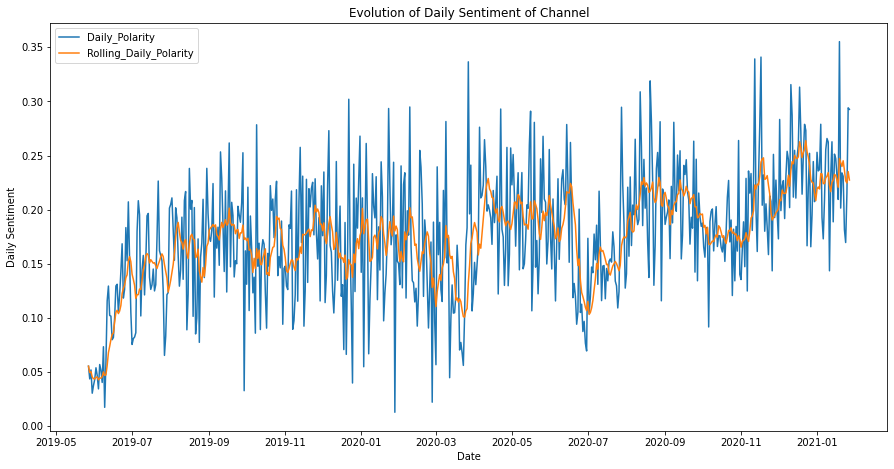

In [44]:
daily_sentiment.plot(figsize=(15, 7.5),
                    ylabel='Daily Sentiment',
                    title='Evolution of Daily Sentiment of Channel')

Now let's compare the evolution in sentiment with the prices of the relevant cryptocurrencies.

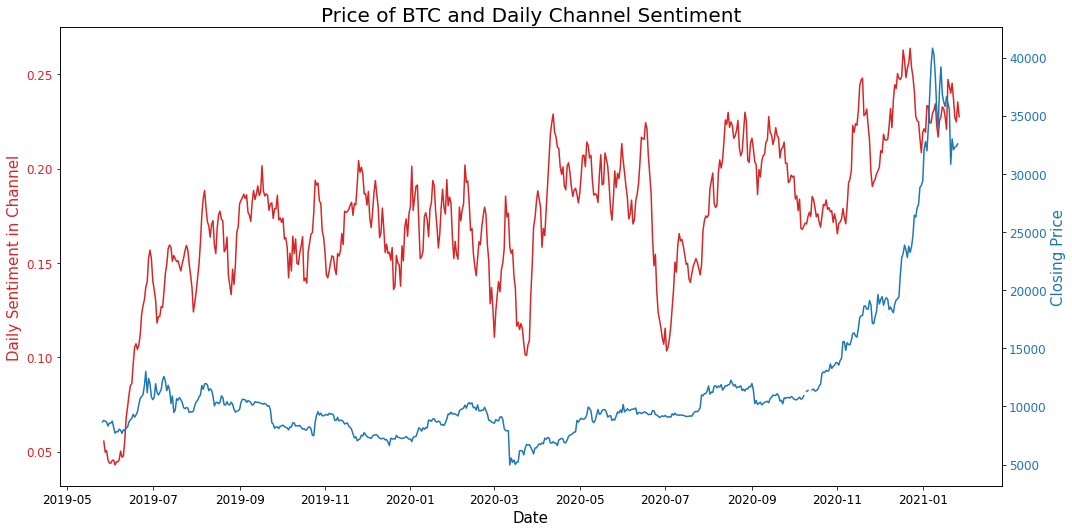

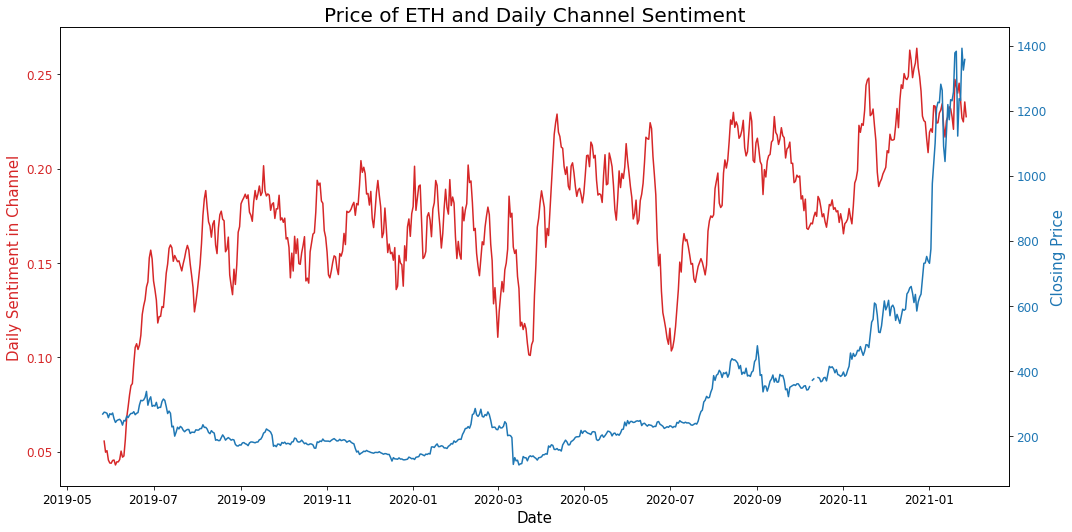

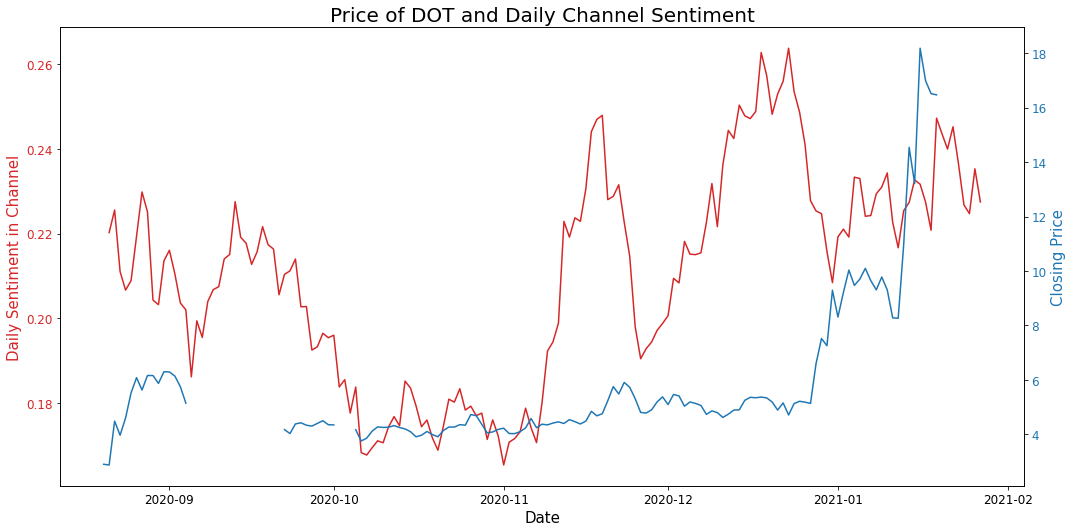

In [45]:
for i, crypto in enumerate(['BTC', 'ETH', 'DOT']): 
    
    start_date = prices[prices[tickers[i]].notna()].index[0]
    cut_price = prices.loc[prices.index > start_date, :]
    sentiment_data = daily_sentiment.loc[daily_sentiment.index > start_date, 'Rolling_Daily_Polarity']
    
    fig, ax1 = plt.subplots()
    plt.title('Price of ' + crypto + ' and Daily Channel Sentiment', fontsize=20)
    fig.set_size_inches(15, 7.5)
    color = 'tab:red'
    ax1.set_xlabel('Date', fontsize=15)
    ax1.set_ylabel('Daily Sentiment in Channel', color=color, fontsize=15)
    ax1.plot(sentiment_data.index, sentiment_data, color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Closing Price', color=color, fontsize=15) 
    ax2.plot(prices.index, prices[tickers[i]], color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=12)

    fig.tight_layout() 

It is visible that in the last days of the analysis, the channel sentiment is up! This is most likely due to a growth in the prices of BTC and ETH.

In [47]:
corr_sentiment_prices = {}
for i, crypto in enumerate(['BTC', 'ETH', 'DOT']): 
    merged = pd.merge(daily_sentiment['Rolling_Daily_Polarity'], prices[tickers[i]], left_index=True, right_index=True)
    corr_sentiment_prices[crypto] = merged.corr().iloc[0, 1]
    corr_mentions_prices = {}
corr_sentiment_prices

{'BTC': 0.5033922527281318,
 'ETH': 0.48267556616337,
 'DOT': 0.36998731899574644}